In [1136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.integrate import solve_ivp
from scipy import optimize
from scipy.optimize import least_squares
from scipy.interpolate import griddata
import constants as const
from scipy.constants import N_A

In [1137]:
Msun = 1.988*1e33
M = 3*Msun
Rsun = 6.96e10
Lsun = 3.826e33
X = 0.3500
Y = 0.5500
Z = 1 - X - Y #Z=0.1000 
#We're using Table #52 from OPAL 

In [1138]:
def txttodf(filename):
    with open(filename) as f:
        lines = f.readlines()
    
    dict = {}
    for k in range(126):
        arr = []
        log_T = []
        table_name = 'Table '+str(k+1)
        for j in range(70):
            arr1 = []
            for i in lines[6+77*k+j].split()[1:]: arr1.append(float(i))
            log_T.append(float(lines[6+77*k+j].split()[0]))
            arr.append(np.array(arr1))
            dict[table_name] = pd.DataFrame(arr)
    
    log_R = []
    for i in lines[4].split()[1:]: log_R.append(float(i))
    
    return dict, log_R, log_T

In [1139]:
filename = 'GN93hz.txt' 
diction, logR_Table, logT_Table = txttodf(filename) 
T52 = diction['Table 52'] 
opacity_T = T52.to_numpy()

In [1140]:
logT_Table = np.array(logT_Table)
logT_Table

array([3.75, 3.8 , 3.85, 3.9 , 3.95, 4.  , 4.05, 4.1 , 4.15, 4.2 , 4.25,
       4.3 , 4.35, 4.4 , 4.45, 4.5 , 4.55, 4.6 , 4.65, 4.7 , 4.75, 4.8 ,
       4.85, 4.9 , 4.95, 5.  , 5.05, 5.1 , 5.15, 5.2 , 5.25, 5.3 , 5.35,
       5.4 , 5.45, 5.5 , 5.55, 5.6 , 5.65, 5.7 , 5.75, 5.8 , 5.85, 5.9 ,
       5.95, 6.  , 6.1 , 6.2 , 6.3 , 6.4 , 6.5 , 6.6 , 6.7 , 6.8 , 6.9 ,
       7.  , 7.1 , 7.2 , 7.3 , 7.4 , 7.5 , 7.6 , 7.7 , 7.8 , 7.9 , 8.  ,
       8.1 , 8.3 , 8.5 , 8.7 ])

In [1141]:
logR_Table = np.array(logR_Table)
logR_Table

array([-8. , -7.5, -7. , -6.5, -6. , -5.5, -5. , -4.5, -4. , -3.5, -3. ,
       -2.5, -2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ])

In [1142]:
#create a function to accept inputs from density and temperature and interpolate

# Setup the grid like scipy interpolate requires it - <function scipy.interpolate._ndgriddata.griddata(points, values, xi, method='linear', fill_value=nan, rescale=False)>
pts = []
vals = []
for i in range(len(logR_Table)):
    for j in range(len(logT_Table)):
        pts.append([logR_Table[i], logT_Table[j]])
        vals.append(T52.values[j][i])

def calc_opacity(rho, T):
    log_R = np.log10(rho/(1e-6*T)**3)
    log_T = np.log10(T)
    
    try:
        opacity = 10**griddata(pts, vals, (log_R, log_T))
    except np.nan(opacity):
        print('nan encountered')
        print(log_R,log_T)

        
    return opacity

In [1143]:
#Define a function to calculate g11

def g11(T):
    T9 = T*1e-9
    g11 = 1 + 3.82*T9 + 1.51*(T9**2) + 0.144*(T9**3) - 0.011*(T9**4)
    
    return g11

In [1144]:
#Define a function to calculate g14

def g14(T):
    T9 = T*1e-9
    g14 = 1 - 2*T9 + 3.41*(T9**2) - 2.43*(T9**3)
    
    return g14

In [1145]:
#Define a function to calculate f11

def f11(rho,T):
    T7 = T*1e-7
    Z1 = 1 #assuming pp chain
    Z2 = 1 #assuming pp chain
    zeta = 1 #assuming from book
    f11 = np.exp((5.92e-3) * Z1 * Z2 * np.sqrt(zeta*rho/T7**3))
    
    return f11

In [1146]:
#Define a function to calculate the energy generation rate from the PP chain

def e_pp(rho,T):
    psi = 1
    T9 = T*1e-9
    f_11 = f11(rho,T)
    g_11 = g11(T)
    X1 = 0.35 #using our X
    e_pp = (2.57e4) * psi * f_11 * g_11 * rho*(X1**2)*(T9**(-2/3))*np.exp(-3.381/(T9**(1/3)))
    
    return e_pp

In [1147]:
#Define a function to calculate the energy generation rate from the CNO cycle

def e_cno(rho,T):
    T9 = T*1e-9
    g_14 = g14(T)
    Z_ = 0.1 #using our Z
    XCNO = (2/3) * Z_
    X1 = 0.35
    e_cno = (8.24e25) * g_14 * XCNO * X1 * rho * (T9**(-2/3)) * np.exp((-15.231*(T9**(-1/3)))-((T9/0.8)**2))
    
    return e_cno

In [1148]:
#Energy generation rate from both pp chain and cno cycle

def energy_rate(rho,T):
    epp = e_pp(rho,T)
    ecno = e_cno(rho,T)
    
    return epp+ecno

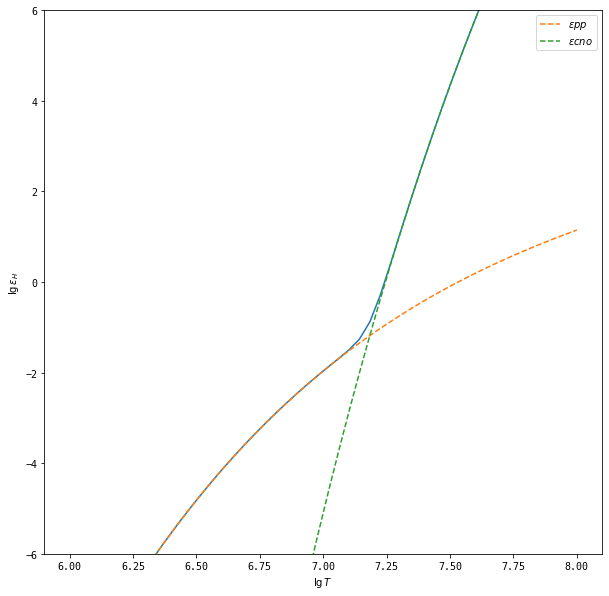

In [1149]:
#Now let's replicate the plot 18.8 in KWW's book to make sure functions are correct
plt.figure(figsize = (10,10))
x = np.linspace(6,8,50)
y = np.log10(energy_rate(1,10**x))

plt.plot(x,y)
plt.plot(x, np.log10(e_pp(1,10**x)),ls = '--', label = r'$\epsilon pp $')
plt.plot(x, np.log10(e_cno(1,10**x)), ls = '--', label = r'$\epsilon cno$')
plt.xlabel(r'$\lg T$')
plt.ylabel(r'$\lg \epsilon_H$')
plt.ylim(-6,6)
plt.legend()

In [1150]:
#Define a function to calculate density, assumed complete ionization so mu can be approximated to ~ 4/3+5x 

def rho_(P,T,X=0.35):
    mu = 4/(3 + 5* X)
    rho = (P - (const.a*T**4/3))*(mu/(N_A*const.k*T))
    
    return rho

In [1151]:
def delrad(m,l,P,rho,T):
    k = calc_opacity(rho,T)
  
    delrad = (3/(16*np.pi*const.a*const.c*const.G))*((P*const.k)/T**4)*(l/m)
    
    return delrad

In [1152]:
del_ad = ((5/3)-1)/(5/3)

In [1153]:
#Let's create the load1 = load_in and load2 = load_out functions
#We're going to use the constant-density model to get load1
#We're going to use homology relations to get load2
#Assuming full ionization in the center 

def load_in(Tc,Pc, factor=1e-12):
    X = 0.35
   
    Ms = Msun*factor 
    rho_c = rho_(Pc,Tc,X=0.35)
   
    ep = energy_rate(rho_c,Tc) 
    l = ep*Ms  

    #from book eq 11.3
    P = Pc - (3*const.G/8*np.pi)*((4*np.pi*rho_c)/3)**(4/3)*(Ms**(2/3))
    
    #from book eq 11.6
    r = ((3*Ms)/(4*np.pi*rho_c))**(1/3)
   
    #now for temperature we have to consider if we have a radiative or convective core
    #so we use the definition of del_rad in 4.30 
   
    del_rad = delrad(Ms,l,P,rho_c,Tc)
    del_ad = ((5/3)-1)/(5/3) #assuming ideal gas and that gamma1=gamma2=gamma3=gamma=5/3 (eq 3.96)
   
    #so now let's check which one dominates
    
    if del_rad < del_ad:

    #for radiative let's look at 11.9 (radiative part)
        kc = calc_opacity(rho_c, Tc)
        T = (Tc**4 - (1/(2*const.a*const.c))*(3/(4*np.pi))**(2/3)*kc*ep*(rho_c**(4/3))*(Ms**(2/3)))**(1/4)
    else:
       
    #for convective use 11.9 (convective part)    
        T = np.exp(np.log(Tc)- ((np.pi/6)**(1/3))*G*del_ad*(rho_c**(4/3))*(Ms**(2/3))*(1/Pc))
    
    #returns our 4 dependent variables in array form
    return np.array([l,P,r,T])

In [1154]:
def rho_PgPrad(rho,T):

    X = 0.35
    mu = 4/(3 + 5* X)
    P_gas = (1/3)*const.a*(T**4) + (N_A*const.k*rho*T)/mu
    
    return P_gas

In [1155]:
def rho_opacity(rho,T):
  
    gs = const.G*Ms/(Rs**2) #surface gravity
    T_eff = (Ls/(4*np.pi*const.sb*(Rs**2)))**(1/4)
   
    kappa = calc_opacity(rho, T_eff)
    
    P_photo = (2/3)*(gs/kappa)*(1+(const.k*Ls)/(4*np.pi*const.c*const.G*Ms))
    
    return P_photo 

In [1156]:
def rho_min(rho,T):
    
    diff = 1 - rho_opacity(rho,T)/rho_PgPrad(rho,T)
    
    return np.abs(diff**2)

In [1157]:
load_out(6.958e+33,1.5344513557801265e+36,178098504574.71844)

array([1.53445136e+36, 3.01221374e+03, 1.78098505e+11, 1.61417326e+04])

In [1158]:
def load_out(Ms,Ls,Rs, factor=0.9999):
    X = 0.35
    mu = 4/(3 + 5* X)
   
    gs = const.G*Ms/(Rs**2) #surface gravity
    T_eff = (Ls/(4*np.pi*const.sb*(Rs**2)))**(1/4)
  
    #now let's use a minimizer to find the min diff between them
    rho_final = optimize.minimize(rho_min, 1e-8, args = (T_eff), method='Nelder-Mead', bounds=[(1e-13,1e-5)])

    if rho_final.success:
        rho = rho_final.x[0]
    else:
        print('no rho')
        
    kappa = calc_opacity(rho, T_eff)
    P = (2/3)*(gs/kappa)*(1+(const.k*Ls)/(4*np.pi*const.c*const.G*Ms))
    
    #returns our 4 dependent variables in array form
    return np.array([Ls,P,Rs,T_eff])

In [1159]:
#Lets define a function for the 4 differential equations

def derivs(M,var):
    
    l,P,r,T = var
    
    rho = rho_(P,T,X = 0.35)
    del_rad = delrad(M,l,P,rho,T)
    del_f = np.minimum(del_rad,del_ad)
    
    dldm = energy_rate(rho,T)
    dPdm = (-const.G*M)/(4*np.pi*(r**4))
    drdm = 1/(4*np.pi*(r**2)*rho)
    dTdm = ((-const.G*M*T)/(4*np.pi*(r**4)*P))*del_f
    
    derivs = np.array([dldm,dPdm,drdm,dTdm])
    
    return derivs

In [1168]:
#Now finally, let's create our shooting function following the "shootf" function

def shoot(guesses, Ms = 3.5*Msun, fit = 0.5, n=int(1e5), in_factor=1e-12, out_factor=0.9999):
    
    #vector with initial guesses
    Ls, Pc, Rs, Tc = guesses 
   
    in_ = load_in(Tc,Pc, factor=in_factor)
    out_ = load_out(Ms,Ls,Rs, factor=out_factor)
   
    # crash minimizer if nan values appear
    if np.isnan(np.sum(in_)) or np.isnan(np.sum(out_)):
        print('nan values')
        return np.array([-np.inf, -np.inf, -np.inf, -np.inf])
    
    # array of masses to solve across
    leaving = np.linspace(in_factor*Ms, fit*Ms, num = n)
    entering = np.linspace(out_factor*Ms,fit*Ms, num = n)
    
    #from core to surface
    sol_core = solve_ivp(derivs, (leaving[0], leaving[-1]), in_, method='RK45', t_eval=leaving)
    
    # determine success of core->surface 
    if sol_core.status == 0:
        # report success
        print('inner done')
    else:
        # report failure
        print('inner failed', sol_core.message)
    
    # solve from surface to core
    sol_surf = solve_ivp(derivs, (entering[0], entering[-1]), out_, method='RK45', t_eval=entering)
    
    # determine success of surface->core 
    if sol_surf.status == 0:
        # report success
        print('outer done')
    else:
        # report failure
        print('outer failed', sol_surf.message)
    
     # assign integrated solution to variables
    leaving_sol = sol_core.y
    entering_sol = sol_surf.y

    
    # determine the difference at the shooting point
    dL = (leaving_sol[0,-1] - entering_sol[0,-1])/Ls
    dP = (leaving_sol[1,-1] - entering_sol[1,-1])/Pc
    dR = (leaving_sol[2,-1] - entering_sol[2,-1])/Rs
    dT = (leaving_sol[3,-1] - entering_sol[3,-1])/Tc
    # return residual array
    print(np.array([dL, dP, dR, dT]))
    return np.array([dL, dP, dR, dT])

def solv(vec_final, Ms= 3.5*Msun, fit=0.5,
            n=int(1e5), in_factor=1e-12, out_factor=0.9999):

    Ls, Pc, Rs, Tc = vec_final
   
    in_ = load_in(Tc, Pc, factor=in_factor)
    out_ = load_out(Ms, Ls, Rs, factor=out_factor)

    leaving = np.linspace(in_factor*Ms, fit*Ms, num = int(n))
    entering = np.linspace(out_factor*Ms,fit*Ms, num = int(n))
    
    sol_core = solve_ivp(derivs, (leaving[0], leaving[-1]), in_, method='RK45', t_eval=leaving)
    sol_surf = solve_ivp(derivs, (entering[0], entering[-1]), out_, method='RK45', t_eval=entering)

    leaving_sol = sol_core.y
    entering_sol = sol_surf.y
    
    # combine mass arrays
    
    mass = np.concatenate([leaving, np.flipud(entering)], axis=0)
    
    # add mass to final array
    solution = np.zeros((5, mass.shape[0]))
    solution[0] = mass
    
    # combine solution arrays
    sols = np.concatenate([leaving_sol, np.fliplr(entering_sol)], axis=1)
    solution[1:5] = sols

    
    return solution
    
    

In [1091]:
def rho_PgPrad(rho,T):
 
    X = 0.35
    mu = 4/(3 + 5* X)
   
    P_gas = (1/3)*const.a*(T**4) + (N_A*const.k*rho*T)/mu
    return P_gas

In [1092]:
#Mesa values

mesa_Tc = (10**7.315714) #lg_Tcntr
mesa_rho= (10**1.042413) #lg_Dcnter

mesa_Pc = (rho_PgPrad(mesa_rho, mesa_Tc))
mesa_R = (10**0.575289)*Rsun #lg_R
mesa_L = (10**2.390383)*Lsun #lg_L

MESA = np.array([mesa_L,mesa_Pc,mesa_R,mesa_Tc])
MESA

array([9.40000243e+35, 2.29833877e+16, 2.61756961e+11, 2.06877853e+07])

In [1017]:
print('Percent Errors: {}'.format(abs(MESA - final.x) / MESA * 100))  # Find percent differences

Percent Errors: [63.2394638  66.76292212 31.9603559  22.62638025]


In [1175]:
# #Let's run it - Commented out because ran already and solution loaded below

# #surface
# Ms = 3.5*Msun
# Ls = (Ms/Msun)**(3.5)*Lsun # eq. 1.88 from Stellar Interiors
# Rs = (Ms/Msun)**(0.75)*Rsun # eq. 1.87 from Stellar Interiors
# # core
# Pc = (3/(8*np.pi))*(const.G*(Ms)**2)/(Rs)**4 # constant density sphere
# Tc = (1/2)*((4/(3+5*0.35))/(N_A*const.k))*(const.G*Ms)/(Rs) # constant density sphere

# # initial guess vector
# vec = np.array([Ls*5,Pc*50,Rs,Tc])

# # shootf args
# args = (Ms, 0.3, int(1e5), 1e-12, 0.9999)
# # set limits for the minimizer
# bounds = ([Ls*1e-1,Pc,Rs,Tc*1e-1],[Ls*10, Pc*100, Rs*1e1, Tc*1e1])



# # run least_squares minimizer to converge model
# # equivalent to the "newton" solver 
# # this minimizes the difference between two shootf runs
# final = least_squares(shoot, vec, args=args, bounds=bounds,
#                       method='dogbox', loss='arctan',
#                       gtol=None,
#                       xtol=None,
#                       ftol=1e-6,
#                       x_scale='jac',
#                      )

# print(final)

# # run solution and create table with results
# solution = solv(final.x, Ms=args[0], fit=args[1], n=1e5, in_factor=args[3], out_factor=args[4])

# Ls, Pc, Rs, Tc = final.x

# # # save dense results table to disk
# # with open('converged_interior_{}.npy'.format(Ms/Msun), 'wb') as f:
# #     np.save(f, solution)

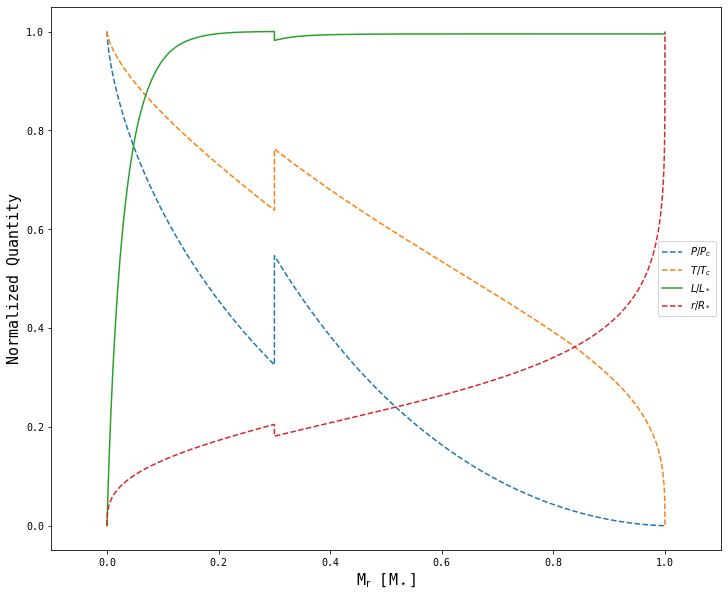

In [1010]:
# plotting

# guesses
# surface
M_star = 3.5*Msun
L_star = (M_star/Msun)**(3.5)*Lsun # eq. 1.88 from Stellar Interior
R_star = (M_star/Msun)**(0.75)*Rsun # eq. 1.87 from Stellar Interior
# core
Pc = (3/(8*np.pi))*(G*(M_star)**2)/(R_star)**4 # constant density sphere,
Tc = (1/2)*((4/(3+5*0.7))/(N_A*const.k))*(const.G*M_star)/(R_star) # constant density sphere

# load solution
solution = np.load('converged_interior_{}.npy'.format(M_star/Msun),allow_pickle=True)

#plot solution
plt.figure(figsize=(12,10))

# plt.plot(solution[0]/M_star, solution[5]/solution[5].max(), color='cornflowerblue', label=r'$\rho~[g/cm^3]$'.format())
plt.plot(solution[0]/M_star, solution[2]/solution[2].max(),linestyle= '--', label=r'$P/P_c$')
plt.plot(solution[0]/M_star, solution[4]/solution[4].max(), linestyle= '--',label='$T/T_c$')
plt.plot(solution[0]/M_star, solution[1]/solution[1].max(),label=r'$L/L_*$')
plt.plot(solution[0]/M_star, solution[3]/solution[3].max(),linestyle= '--', label=r'$r/R_*$')


plt.xlabel(r'M$_\mathrm{r}$ [M$_\star$]',fontsize=15)
plt.ylabel(r'Normalized Quantity', fontsize=15)
plt.legend(fontsize=13, bbox_to_anchor=(0.55,0.5))
plt.xlim(-0.1,1.1)
plt.legend(loc='best')